## Transformers Architecture 

#### First Transformer

In [1]:
import pandas as pd
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler


In [2]:
file_path = '../../Data/data_preprocessed/predicition_data/fridge_data_for_prediction.csv'
# Read the CSV file into a DataFrame
dataset = pd.read_csv(file_path)
dataset

,measurement,appliance,value,timestamp
0,Electricity,fridge,73.769,1661990400
1,Electricity,fridge,73.164,1661990430
2,Electricity,fridge,73.134,1661990460
3,Electricity,fridge,73.115,1661990490
4,Electricity,fridge,73.391,1661990520
...,...,...,...,...
1026925,Electricity,fridge,82.292,1693526250
1026926,Electricity,fridge,81.497,1693526280
1026927,Electricity,fridge,81.587,1693526310
1026928,Electricity,fridge,81.270,1693526340


C:\Users\Ghada\AppData\Local\Temp\ipykernel_26484\3551708709.py:11: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  mask = (dataset['datetime'] >= pd.to_datetime(start_time, unit='s')) & (dataset['datetime'] <= pd.to_datetime(end_time, unit='s'))
C:\Users\Ghada\AppData\Local\Temp\ipykernel_26484\3551708709.py:17: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  plt.title(f'Fridge Consumption from {pd.to_datetime(start_time, unit="s")} to {pd.to_datetime(end_time, unit="s")}')


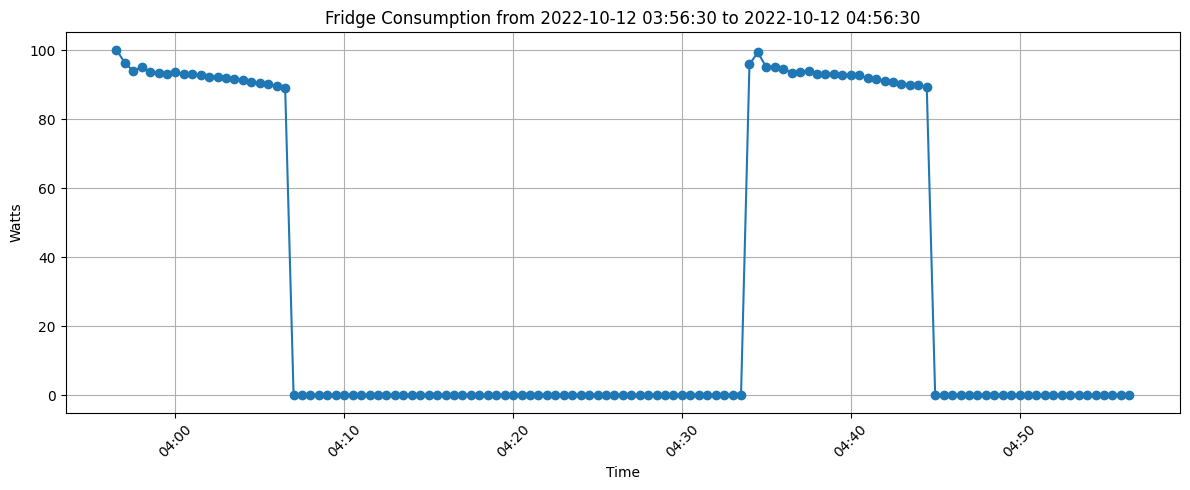

In [5]:
import matplotlib.dates as mdates

# Define your start and end timestamps (in 'YYYY-MM-DD HH:MM:SS' format)
start_time = '1665546990'
end_time = '1665550590'

# Ensure 'datetime' column exists and is in datetime format
dataset['datetime'] = pd.to_datetime(dataset['timestamp'], unit='s')

# Filter the DataFrame between the two timestamps
mask = (dataset['datetime'] >= pd.to_datetime(start_time, unit='s')) & (dataset['datetime'] <= pd.to_datetime(end_time, unit='s'))
df_window = dataset.loc[mask]

# Plot the values in the selected window
plt.figure(figsize=(12, 5))
plt.plot(df_window['datetime'], df_window['value'], marker='o')
plt.title(f'Fridge Consumption from {pd.to_datetime(start_time, unit="s")} to {pd.to_datetime(end_time, unit="s")}')
plt.xlabel('Time')
plt.ylabel('Watts')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [3]:
import numpy as np
import tensorflow as tf
from keras import layers, models

In [7]:
class PositionalEncoding(layers.Layer):
    def __init__(self, sequence_len, d_model):
        super().__init__()
        self.pos_encoding = self.positional_encoding(sequence_len, d_model)

    def get_angles(self, pos, i, d_model):
        angles = pos / np.power(10000, (2 * (i//2)) / d_model)
        return angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            np.arange(position)[:, np.newaxis],
            np.arange(d_model)[np.newaxis, :],
            d_model
        )
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, x):
        return x + self.pos_encoding[:, :tf.shape(x)[1], :]


In [8]:
def build_transformer_model(input_seq_len=20160, output_seq_len=288, d_model=64, num_heads=4, ff_dim=128, dropout=0.1):
    inputs = tf.keras.Input(shape=(input_seq_len, 1))
    
    # Dense embedding
    x = layers.Dense(d_model)(inputs)
    x = PositionalEncoding(input_seq_len, d_model)(x)
    
    # Transformer Encoder block
    for _ in range(2):  # Two encoder blocks
        attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
        attn_output = layers.Dropout(dropout)(attn_output)
        x = layers.LayerNormalization()(x + attn_output)

        ffn_output = layers.Dense(ff_dim, activation='relu')(x)
        ffn_output = layers.Dense(d_model)(ffn_output)
        x = layers.LayerNormalization()(x + ffn_output)
    
    # Pooling and prediction
    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(output_seq_len)(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


In [10]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

# Assuming df is your DataFrame with a column 'consumption'
values = dataset['value'].values.reshape(-1, 1)  # shape: (n_samples, 1)

scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(values)
scaled_values.shape


(1026930, 1)

In [11]:
def create_sequences(data, input_len=20160, output_len=288, step=100, max_samples=None):
    X, y = [], []
    total = len(data)
    i = 0
    while i + input_len + output_len < total:
        X.append(data[i:i+input_len])
        y.append(data[i+input_len:i+input_len+output_len].flatten())
        i += step
        if max_samples and len(X) >= max_samples:
            break
    return np.array(X), np.array(y)


In [45]:
X, y = create_sequences(scaled_values, input_len=1000, output_len=288, step=500, max_samples=5000)


In [46]:
def split_data(X, y, train_ratio=0.7, val_ratio=0.15):
    total = len(X)
    train_end = int(total * train_ratio)
    val_end = int(total * (train_ratio + val_ratio))

    X_train, y_train = X[:train_end], y[:train_end]
    X_val, y_val = X[train_end:val_end], y[train_end:val_end]
    X_test, y_test = X[val_end:], y[val_end:]

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape


((1436, 1000, 1),
 (1436, 288),
 (308, 1000, 1),
 (308, 288),
 (308, 1000, 1),
 (308, 288))

In [47]:
model = build_transformer_model(input_seq_len=1000, output_seq_len=288)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Fit the model
history=model.fit(X_train, y_train, 
          validation_data=(X_val, y_val),
          epochs=20, batch_size=32)

Epoch 1/20
45/45 [==============================] - 11s 227ms/step - loss: 0.1467 - mae: 0.3220 - val_loss: 0.1365 - val_mae: 0.3544
Epoch 2/20
45/45 [==============================] - 10s 222ms/step - loss: 0.1141 - mae: 0.2892 - val_loss: 0.1348 - val_mae: 0.3535
Epoch 3/20
45/45 [==============================] - 10s 221ms/step - loss: 0.1128 - mae: 0.2861 - val_loss: 0.1349 - val_mae: 0.3557
Epoch 4/20
45/45 [==============================] - 10s 221ms/step - loss: 0.1128 - mae: 0.2863 - val_loss: 0.1345 - val_mae: 0.3534
Epoch 5/20
45/45 [==============================] - 10s 222ms/step - loss: 0.1127 - mae: 0.2864 - val_loss: 0.1350 - val_mae: 0.3570
Epoch 6/20
45/45 [==============================] - 10s 222ms/step - loss: 0.1126 - mae: 0.2859 - val_loss: 0.1349 - val_mae: 0.3561
Epoch 7/20
45/45 [==============================] - 10s 222ms/step - loss: 0.1125 - mae: 0.2862 - val_loss: 0.1345 - val_mae: 0.3561
Epoch 8/20
45/45 [==============================] - 10s 221ms/step - 

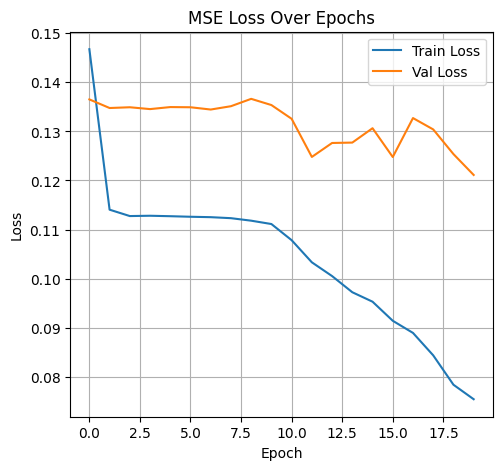

In [48]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('MSE Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


10/10 [==============================] - 1s 77ms/step


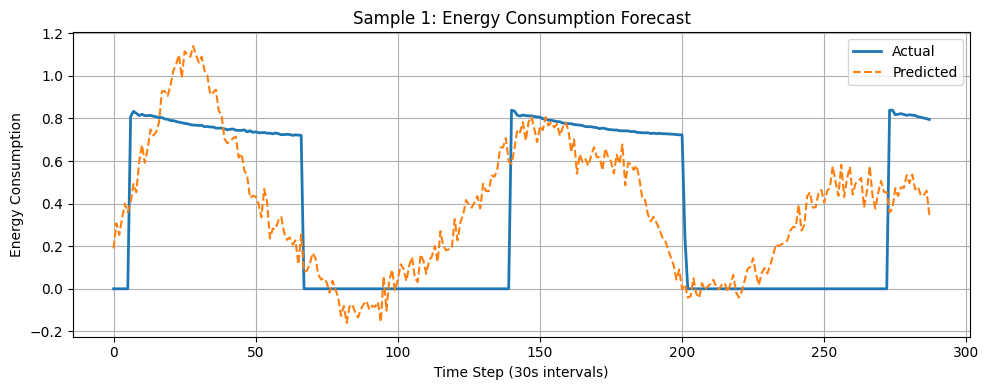

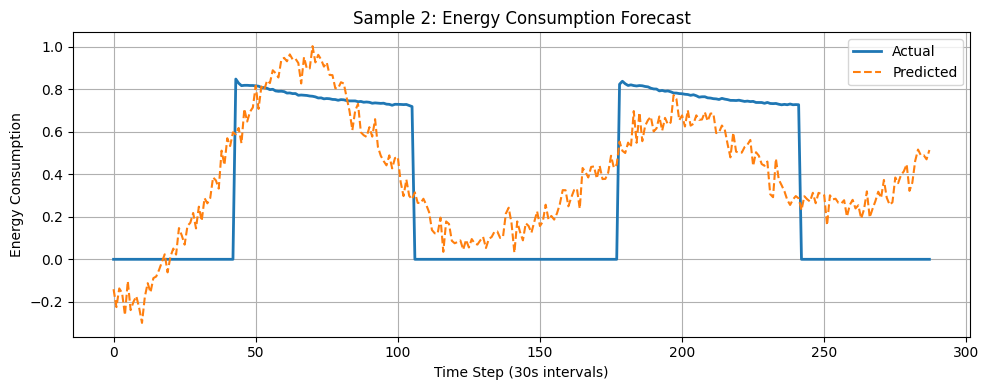

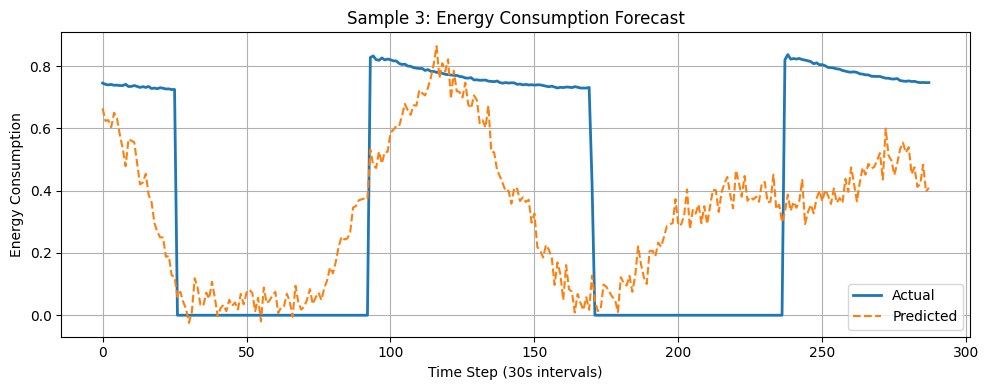

In [49]:
import matplotlib.pyplot as plt
import numpy as np

y_pred = model.predict(X_test)
n_examples = 3  # Number of samples to plot
time_axis = np.arange(288)  # 24 hours at 30s granularity

for i in range(n_examples):
    plt.figure(figsize=(10, 4))
    plt.plot(time_axis, y_test[i], label='Actual', linewidth=2)
    plt.plot(time_axis, y_pred[i], label='Predicted', linestyle='--')
    plt.title(f'Sample {i+1}: Energy Consumption Forecast')
    plt.xlabel('Time Step (30s intervals)')
    plt.ylabel('Energy Consumption')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


#### Second Transformer

In [9]:
import torch
import torch.nn as nn
import numpy as np
import time
import math
from matplotlib import pyplot

torch.manual_seed(0)
np.random.seed(0)


In [ ]:
calculate_loss_over_all_values = False

input_window = 100
output_window = 5
batch_size = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Different Approachs : Autoformer

In [4]:
dataset= dataset.set_index('timestamp')
dataset.index = pd.to_datetime(dataset.index, unit='s')
df=dataset[['value']].copy()
df

,value
timestamp,
2022-09-01 00:00:00,73.769
2022-09-01 00:00:30,73.164
2022-09-01 00:01:00,73.134
2022-09-01 00:01:30,73.115
2022-09-01 00:02:00,73.391
...,...
2023-08-31 23:57:30,82.292
2023-08-31 23:58:00,81.497
2023-08-31 23:58:30,81.587


In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(dataset['value'].values.reshape(-1, 1)) 
scaled.shape


(1026930, 1)

In [7]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
import torch
import torch.nn as nn
import numpy as np
import time
import math
from matplotlib import pyplot

torch.manual_seed(0)
np.random.seed(0)


Data has 1026930 time steps.
Decomposing the time series...
Decomposition complete.


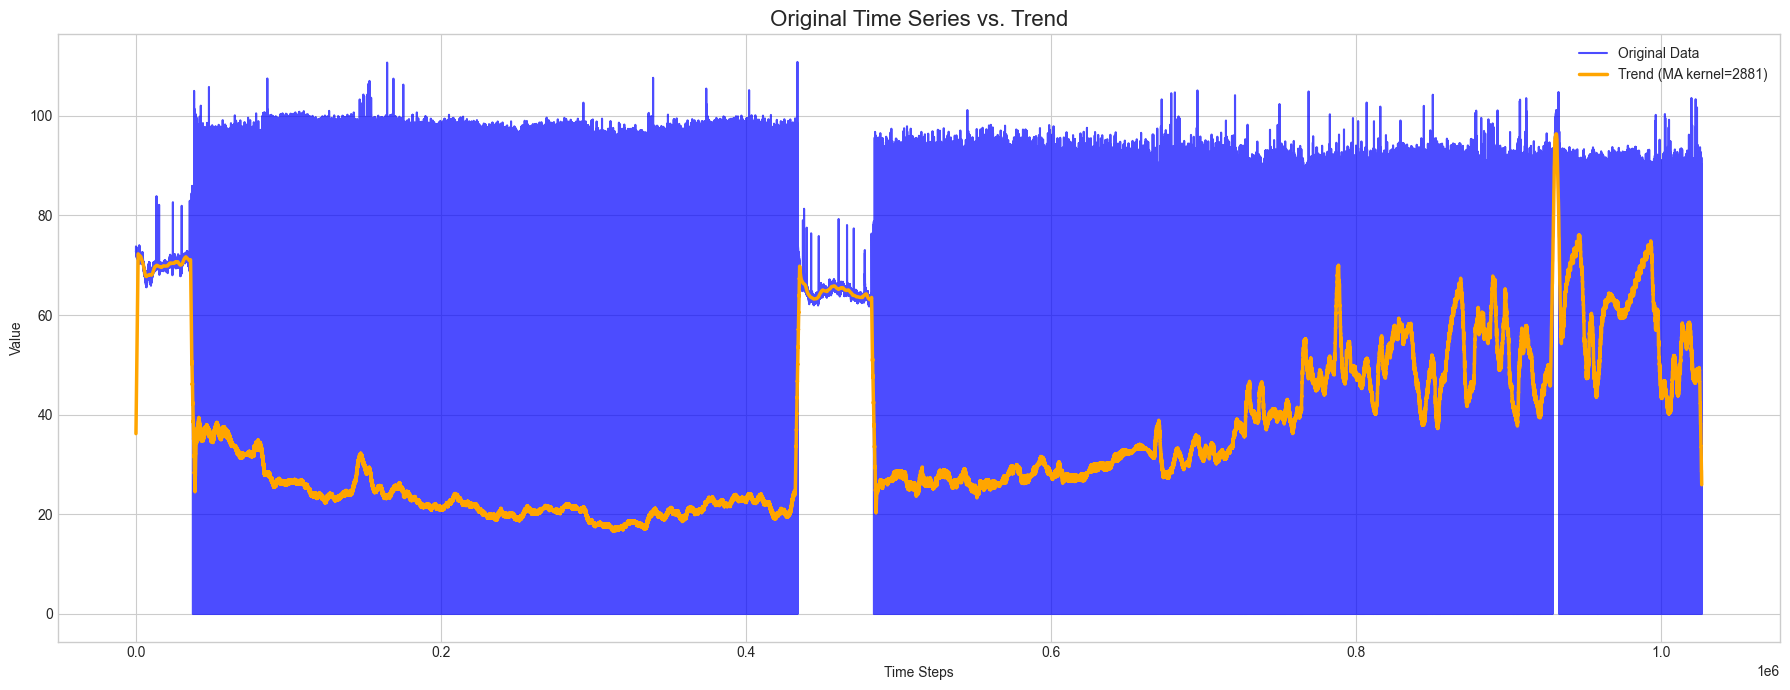

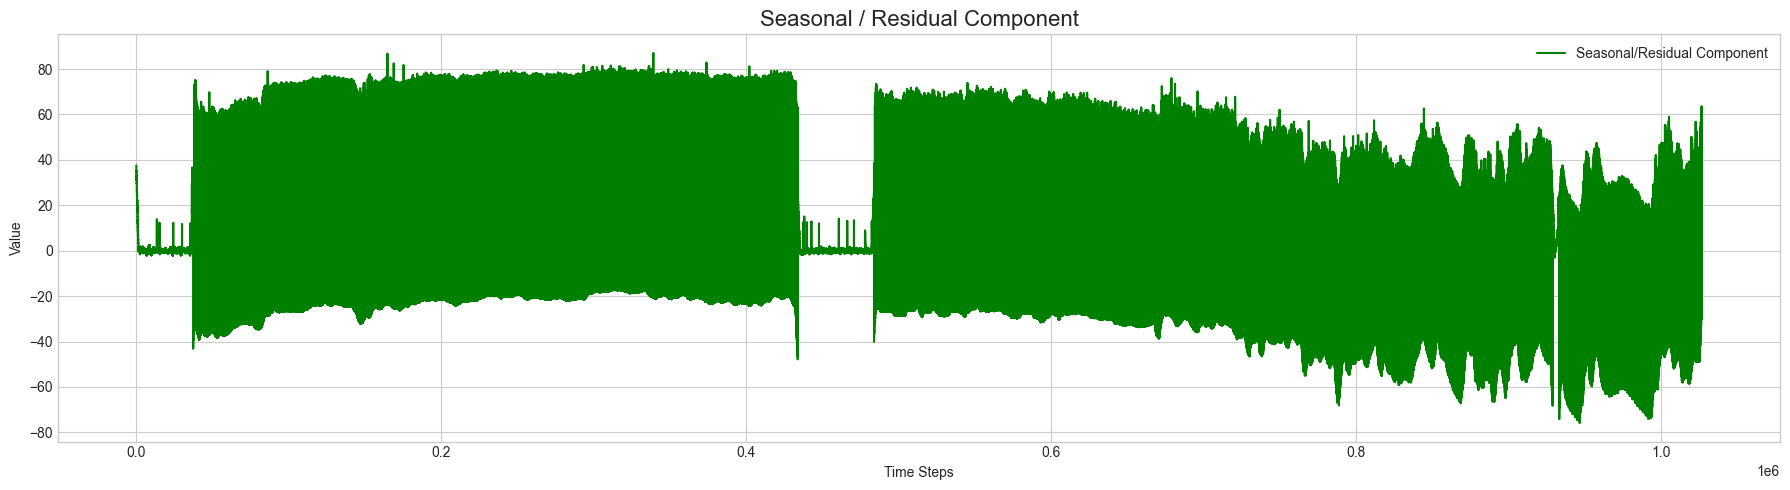

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# The decomposition function (no changes needed here)
def series_decomposition(x: torch.Tensor, kernel_size: int) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Performs classical time series decomposition into trend and seasonal components.
    Uses a centered moving average for trend extraction.
    """
    padding = (kernel_size - 1) // 2
    x_perm = x.permute(0, 2, 1)
    trend = F.avg_pool1d(x_perm, kernel_size=kernel_size, stride=1, padding=padding)
    if kernel_size % 2 == 0:
        trend = F.pad(trend, (0, 1), mode='replicate')
    trend = trend.permute(0, 2, 1)
    seasonal = x - trend
    return seasonal, trend

# ==============================================================================
# --- Step 1: Load Your Data ---
# ==============================================================================

    # Extract the data from the specified column into a NumPy array
data = df['value'].values
    


# Proceed only if data was loaded successfully
if data is not None:
    # Get the sequence length
    seq_len = len(data)
    print(f"Data has {seq_len} time steps.")

    # Prepare the data for decomposition: convert to a 3D PyTorch tensor
    # Shape: (batch_size, seq_len, features) -> (1, seq_len, 1)
    data_tensor = torch.tensor(data, dtype=torch.float32).view(1, seq_len, 1)


    # ==============================================================================
    # --- Step 2: Set Decomposition Parameters ---
    # ==============================================================================
    
    # For 30-second data, a 24-hour period has 24 * 60 * 2 = 2880 samples.
    # Use an ODD kernel size for a perfectly centered moving average.
    kernel_size = 2881 # This represents a 24-hour moving average.
                       # Adjust this if your primary seasonal cycle is different (e.g., weekly).

    # ==============================================================================
    # --- Step 3: Apply Decomposition and Visualize ---
    # ==============================================================================
    
    print("Decomposing the time series...")
    seasonal, trend = series_decomposition(data_tensor, kernel_size)
    print("Decomposition complete.")
    
    # Squeeze to remove extra dimensions for plotting
    trend_numpy = trend.squeeze().detach().numpy()
    seasonal_numpy = seasonal.squeeze().detach().numpy()
    
    # --- Plot Original vs. Trend ---
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(18, 7))
    plt.plot(data, label='Original Data', alpha=0.7, color='blue')
    plt.plot(trend_numpy, label=f'Trend (MA kernel={kernel_size})', linewidth=2.5, color='orange')
    plt.title("Original Time Series vs. Trend", fontsize=16)
    plt.xlabel("Time Steps")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Plot Seasonal/Residual Component ---
    plt.figure(figsize=(18, 5))
    plt.plot(seasonal_numpy, label='Seasonal/Residual Component', color='green')
    plt.title("Seasonal / Residual Component", fontsize=16)
    plt.xlabel("Time Steps")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    plt.show()


--- Task Parameters ---
Input History (I):   5760 steps (2 days)
Forecast Horizon (O): 2880 steps (1 day)
-----------------------

Created one sample from your data with shape: torch.Size([1, 5760, 1])
Generated decoder inputs:
  - Seasonal (Xdes) shape: torch.Size([1, 5760, 1])
  - Trend (Xdet) shape:    torch.Size([1, 5760, 1])

Generating plots to visualize the decoder input construction...


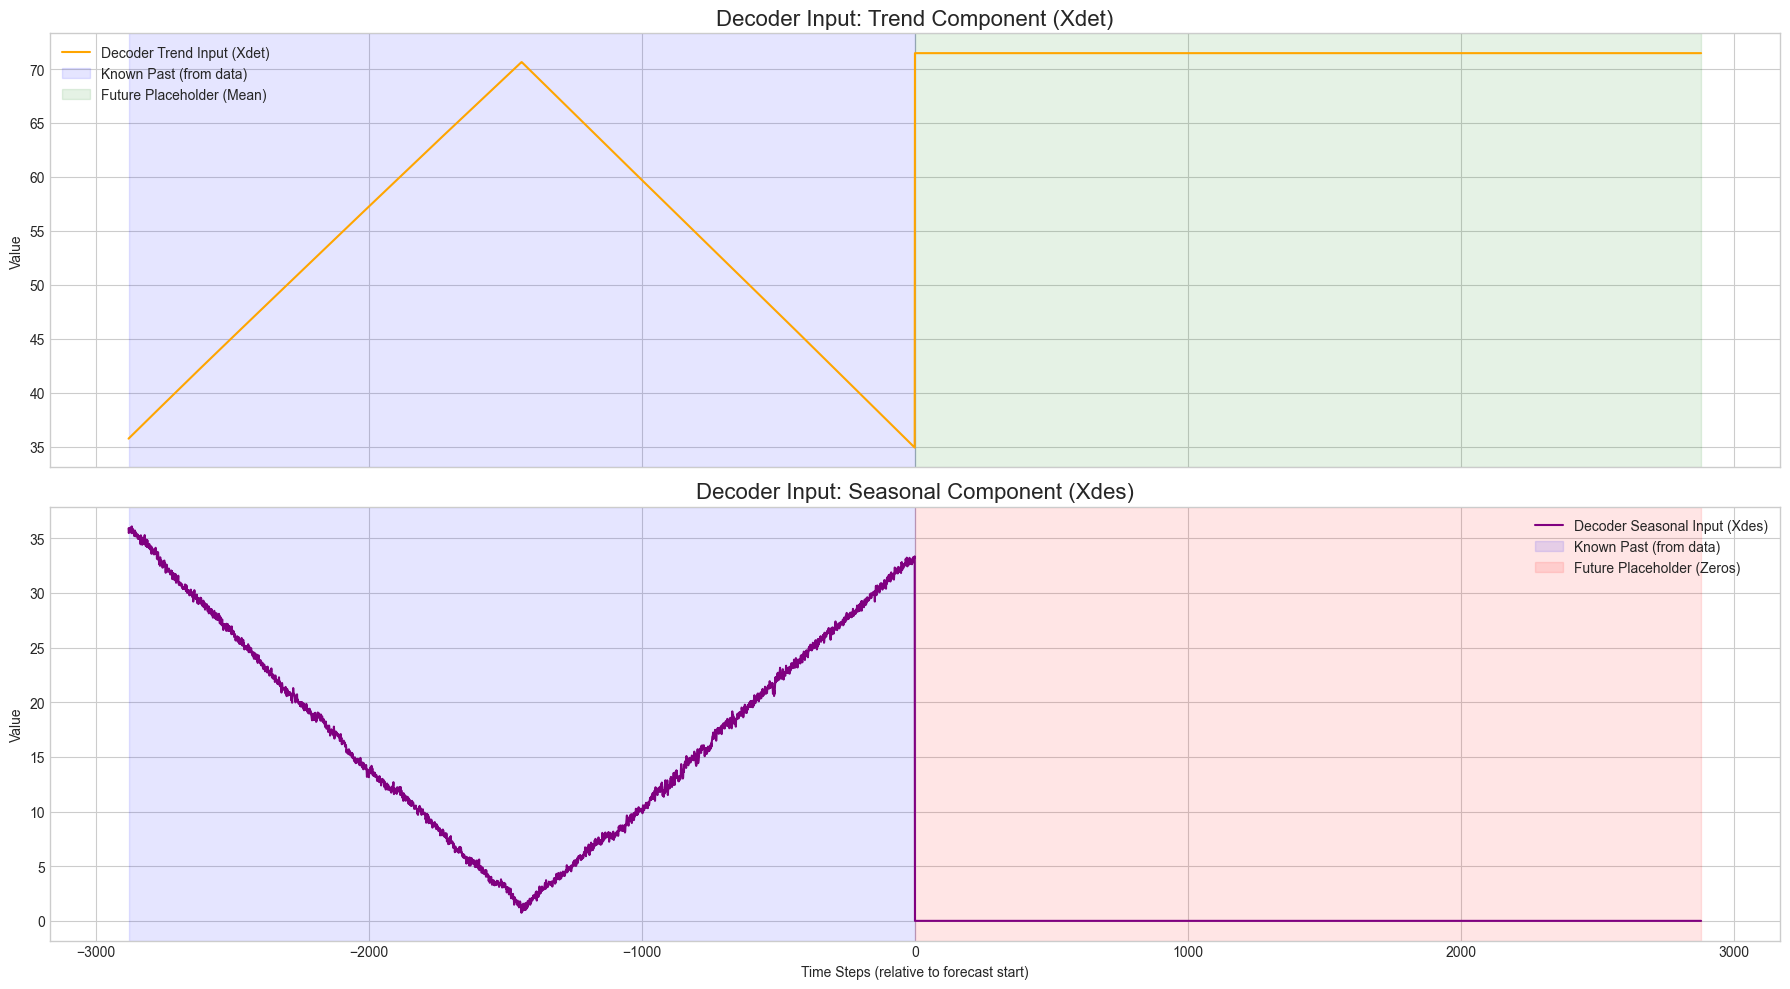

In [10]:
def prepare_autoformer_decoder_inputs(Xen: torch.Tensor, O: int, kernel_size: int) -> tuple[torch.Tensor, torch.Tensor]:
    """Prepares the initial inputs for the Autoformer decoder."""
    B, I, d = Xen.shape
    I_half = I // 2
    Xen_half = Xen[:, I_half:, :]
    Xens, Xent = series_decomposition(Xen_half, kernel_size)
    X_mean_placeholder = Xen.mean(dim=1, keepdim=True).expand(B, O, d)
    X_seasonal_placeholder = torch.zeros((B, O, d), dtype=Xen.dtype, device=Xen.device)
    Xdes = torch.cat([Xens, X_seasonal_placeholder], dim=1)
    Xdet = torch.cat([Xent, X_mean_placeholder], dim=1)
    return Xdes, Xdet

# ==============================================================================
# --- Step 1: Loading Data ---
# ==============================================================================


data = df['value'].values
 

# ==============================================================================
# --- Step 2: Define Parameters for "Forecast Next Day" Task ---
# ==============================================================================
SAMPLES_PER_DAY = 2880

# Model Hyperparameters
I = 2 * SAMPLES_PER_DAY  # Input length: Use past 2 days of data (5760 points)
O = 1 * SAMPLES_PER_DAY  # Output length: Predict next 1 day (2880 points)
d = 1                      # Dimension: 1 (univariate consumption data)
kernel_size = SAMPLES_PER_DAY + 1  # 2881 (for daily seasonality)

print(f"\n--- Task Parameters ---")
print(f"Input History (I):   {I} steps ({I // SAMPLES_PER_DAY} days)")
print(f"Forecast Horizon (O): {O} steps ({O // SAMPLES_PER_DAY} day)")
print(f"-----------------------\n")

# ==============================================================================
# --- Step 3: Create a Single Sample and Process It ---
# ==============================================================================

# We need at least 'I' data points to create one sample.
if len(data) >= I:
    # Take the FIRST possible sample from your data
    xen_sample_np = data[:I]
    
    # Reshape for the model: (seq_len,) -> (batch_size, seq_len, dim)
    Xen_batch = torch.tensor(xen_sample_np, dtype=torch.float32).view(1, I, d)
    
    print(f"Created one sample from your data with shape: {Xen_batch.shape}")

    # Generate the decoder inputs for this single sample
    Xdes, Xdet = prepare_autoformer_decoder_inputs(Xen_batch, O, kernel_size)
    
    print(f"Generated decoder inputs:")
    print(f"  - Seasonal (Xdes) shape: {Xdes.shape}")
    print(f"  - Trend (Xdet) shape:    {Xdet.shape}\n")

    # ==============================================================================
    # --- Step 4: Visualize the Result for this Sample ---
    # ==============================================================================
    
    print("Generating plots to visualize the decoder input construction...")
    
    # Convert tensors back to numpy for plotting
    xdes_np = Xdes.squeeze().numpy()
    xdet_np = Xdet.squeeze().numpy()
    
    # Create x-axis for plotting
    # Time steps from -I/2 to O
    time_steps_decoder = np.arange(-I // 2, O)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 10), sharex=True)
    plt.style.use('seaborn-v0_8-whitegrid')

    # --- Plot 1: Trend Component (Xdet) ---
    ax1.plot(time_steps_decoder, xdet_np, label='Decoder Trend Input (Xdet)', color='orange')
    ax1.axvspan(-I//2, 0, color='blue', alpha=0.1, label='Known Past (from data)')
    ax1.axvspan(0, O, color='green', alpha=0.1, label='Future Placeholder (Mean)')
    ax1.set_ylabel("Value")
    ax1.set_title("Decoder Input: Trend Component (Xdet)", fontsize=16)
    ax1.legend()
    
    # --- Plot 2: Seasonal Component (Xdes) ---
    ax2.plot(time_steps_decoder, xdes_np, label='Decoder Seasonal Input (Xdes)', color='purple')
    ax2.axvspan(-I//2, 0, color='blue', alpha=0.1, label='Known Past (from data)')
    ax2.axvspan(0, O, color='red', alpha=0.1, label='Future Placeholder (Zeros)')
    ax2.set_xlabel("Time Steps (relative to forecast start)")
    ax2.set_ylabel("Value")
    ax2.set_title("Decoder Input: Seasonal Component (Xdes)", fontsize=16)
    ax2.legend()

    plt.tight_layout()
    plt.show()

else:
    print(f"Error: Your data has {len(data)} points, but at least {I} are needed to create one sample.")

In [11]:
class SeriesDecomp(nn.Module):
    def __init__(self, kernel_size):
        super(SeriesDecomp, self).__init__()
        self.moving_avg = nn.AvgPool1d(kernel_size=kernel_size, stride=1, padding=(kernel_size - 1) // 2)
    def forward(self, x):
        trend = self.moving_avg(x.permute(0, 2, 1)).permute(0, 2, 1)
        seasonal = x - trend
        return seasonal, trend

In [12]:
class AutoCorrelation(nn.Module):
    def __init__(self, factor=1, scale=None, attention_dropout=0.1):
        super(AutoCorrelation, self).__init__()
        self.factor = factor
        self.scale = scale
        self.dropout = nn.Dropout(attention_dropout)
    def time_delay_agg_training(self, values, corr):
        head, channel, length = values.shape[1], values.shape[2], values.shape[3]
        top_k = int(self.factor * math.log(length))
        mean_value = torch.mean(torch.mean(corr, dim=1), dim=1)
        index = torch.topk(torch.mean(mean_value, dim=0), top_k, dim=-1)[1]
        weights = torch.stack([mean_value[:, index[i]] for i in range(top_k)], dim=-1)
        tmp_corr = torch.softmax(weights, dim=-1)
        tmp_values = values
        delays_agg = torch.zeros_like(values).float()
        for i in range(top_k):
            pattern = torch.roll(tmp_values, -int(index[i]), -1)
            delays_agg += pattern * (tmp_corr[:, i].unsqueeze(1).unsqueeze(1).unsqueeze(1).repeat(1, head, channel, length))
        return delays_agg
    def forward(self, queries, keys, values, mask=None):
        B, L, H, E = queries.shape
        _, S, _, D = values.shape
        if L > S:
            zeros = torch.zeros_like(queries[:, :(L - S), :]).float()
            values = torch.cat([values, zeros], dim=1)
            keys = torch.cat([keys, zeros], dim=1)
        else:
            values, keys = values[:, :L, :, :], keys[:, :L, :, :]
        q_fft = torch.fft.rfft(queries.permute(0, 2, 3, 1).contiguous(), dim=-1)
        k_fft = torch.fft.rfft(keys.permute(0, 2, 3, 1).contiguous(), dim=-1)
        corr = torch.fft.irfft(q_fft * torch.conj(k_fft), dim=-1)
        V = self.time_delay_agg_training(values.permute(0, 2, 3, 1).contiguous(), corr).permute(0, 3, 1, 2)
        return self.dropout(V), None

In [13]:
class AutoCorrelationLayer(nn.Module):
    def __init__(self, correlation, d_model, n_heads, d_keys=None, d_values=None):
        super(AutoCorrelationLayer, self).__init__()
        self.inner_correlation = correlation
        self.query_projection = nn.Linear(d_model, (d_keys or d_model // n_heads) * n_heads)
        self.key_projection = nn.Linear(d_model, (d_keys or d_model // n_heads) * n_heads)
        self.value_projection = nn.Linear(d_model, (d_values or d_model // n_heads) * n_heads)
        self.out_projection = nn.Linear((d_values or d_model // n_heads) * n_heads, d_model)
        self.n_heads = n_heads
    def forward(self, queries, keys, values, mask=None):
        B, L, _ = queries.shape
        _, S, _ = keys.shape
        queries = self.query_projection(queries).view(B, L, self.n_heads, -1)
        keys = self.key_projection(keys).view(B, S, self.n_heads, -1)
        values = self.value_projection(values).view(B, S, self.n_heads, -1)
        out, _ = self.inner_correlation(queries, keys, values, mask)
        return self.out_projection(out.view(B, L, -1))

In [14]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff=None, dropout=0.1, activation="relu"):
        super(EncoderLayer, self).__init__()
        self.correlation_layer = AutoCorrelationLayer(AutoCorrelation(), d_model, n_heads)
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff or 4 * d_model, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff or 4 * d_model, out_channels=d_model, kernel_size=1)
        self.norm1, self.norm2 = nn.LayerNorm(d_model), nn.LayerNorm(d_model)
        self.dropout, self.activation = nn.Dropout(dropout), F.relu if activation == "relu" else F.gelu
    def forward(self, x):
        new_x, _ = self.correlation_layer(x, x, x)
        x = x + self.dropout(new_x)
        y = x = self.norm1(x)
        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))
        return self.norm2(x + y)

In [15]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff=None, dropout=0.1, activation="relu"):
        super(DecoderLayer, self).__init__()
        self.self_correlation = AutoCorrelationLayer(AutoCorrelation(), d_model, n_heads)
        self.cross_correlation = AutoCorrelationLayer(AutoCorrelation(), d_model, n_heads)
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff or 4 * d_model, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff or 4 * d_model, out_channels=d_model, kernel_size=1)
        self.norm1, self.norm2, self.norm3 = nn.LayerNorm(d_model), nn.LayerNorm(d_model), nn.LayerNorm(d_model)
        self.dropout, self.activation = nn.Dropout(dropout), F.relu if activation == "relu" else F.gelu
    def forward(self, x, cross, x_mask=None, cross_mask=None):
        x = x + self.dropout(self.self_correlation(x, x, x)[0])
        x = self.norm1(x)
        x = x + self.dropout(self.cross_correlation(x, cross, cross)[0])
        y = x = self.norm2(x)
        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))
        return self.norm3(x + y)

In [16]:
class MyPositionalEmbedding(nn.Module):
    # Removed the hardcoded default `max_len=5000`
    def __init__(self, d_model, max_len):
        super(MyPositionalEmbedding, self).__init__()
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False
        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    def forward(self, x):
        return self.pe[:, :x.size(1)]

In [17]:
class Autoformer(nn.Module):
    def __init__(self, seq_len, pred_len, d_model, enc_in, dec_in, c_out, 
                 n_heads, e_layers, d_layers, d_ff, kernel_size, dropout):
        super(Autoformer, self).__init__()
        self.seq_len, self.pred_len = seq_len, pred_len
        self.decomp = SeriesDecomp(kernel_size)
        self.enc_embedding = nn.Linear(enc_in, d_model)
        self.dec_embedding = nn.Linear(dec_in, d_model)
        
        # =================== THE FIX IS HERE ===================
        # Calculate max_len dynamically and pass it to MyPositionalEmbedding
        max_len = max(self.seq_len, self.pred_len + self.seq_len // 2)
        self.pos_embedding = MyPositionalEmbedding(d_model, max_len=max_len)
        print(f"Positional embedding created with max_len={max_len}")
        # =======================================================
        
        self.encoder = nn.ModuleList([EncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(e_layers)])
        self.decoder = nn.ModuleList([DecoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(d_layers)])
        self.projection = nn.Linear(d_model, c_out, bias=True)

    def forward(self, x_enc):
        mean = torch.mean(x_enc, dim=1).unsqueeze(1).repeat(1, self.pred_len, 1)
        zeros = torch.zeros([x_enc.shape[0], self.pred_len, x_enc.shape[2]], device=x_enc.device)
        seasonal_init, trend_init = self.decomp(x_enc[:, -self.seq_len//2:, :])
        dec_inp_seasonal = torch.cat([seasonal_init, zeros], dim=1)
        dec_inp_trend = torch.cat([trend_init, mean], dim=1)
        
        enc_out = self.enc_embedding(x_enc) + self.pos_embedding(x_enc)
        for layer in self.encoder:
            enc_out = layer(enc_out)

        dec_out_seasonal = self.dec_embedding(dec_inp_seasonal) + self.pos_embedding(dec_inp_seasonal)
        dec_out_trend = self.dec_embedding(dec_inp_trend) + self.pos_embedding(dec_inp_trend)
        for i in range(len(self.decoder)):
            dec_out_seasonal = self.decoder[i](dec_out_seasonal, enc_out)
            dec_out_trend = self.decoder[i](dec_out_trend, enc_out)
            
        final_dec_out = dec_out_seasonal + dec_out_trend
        return self.projection(final_dec_out)[:, -self.pred_len:, :]

In [20]:

data = df['value'].values
data = data.reshape(-1, 1)  # Ensure data is 2D for MinMaxScaler
scaler = MinMaxScaler() 
data = scaler.fit_transform(data)  # Scale the data to [0, 1]

# --- Step 2: Define Parameters ---
SAMPLES_PER_DAY = 2880
config = {
    'seq_len': 2 * SAMPLES_PER_DAY,
    'pred_len': 1 * SAMPLES_PER_DAY,
    'd_model': 64, 'enc_in': 1, 'dec_in': 1, 'c_out': 1, 'n_heads': 8,
    'e_layers': 2, 'd_layers': 1, 'd_ff': 256,
    'kernel_size': SAMPLES_PER_DAY + 1, 'dropout': 0.1,
}

# --- Step 3: Instantiate Model and Test ---
if len(data) >= config['seq_len']:
    model = Autoformer(**config)
    sample_tensor = torch.tensor(data[:config['seq_len']], dtype=torch.float32).view(1, config['seq_len'], 1)
    
    model.eval()
    with torch.no_grad():
        prediction = model(sample_tensor)
        
    print(f"\nInput shape:  {sample_tensor.shape}")
    print(f"Output shape: {prediction.shape}")
    print(f"Expected output shape: (1, {config['pred_len']}, 1)")
    assert prediction.shape == (1, config['pred_len'], 1)
    print("\n✅ Model forward pass successful and output shape is correct!")
else:
    print(f"Error: Data too short. Need {config['seq_len']} points, but have {len(data)}.")

Positional embedding created with max_len=5760


ValueError: not enough values to unpack (expected 2, got 1)